In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

### Importing the usual stuff

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
promoter_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, promoter_TSS, reverse=True)

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Function for making sliding window mutants

In [7]:
def get_swapped_mutants(starter_seq, start_i,
                        window_size=10):
    element = starter_seq[start_i:(start_i + window_size)]
    new_element = ''
    for i in range(len(element)):
        # replace with a base different from the original base
        l = ['A', 'T', 'G', 'C']
        l.remove(element[i])
        new_element += np.random.choice(l)[0]
    swapped_mutant = starter_seq[:start_i] + new_element + starter_seq[(start_i + window_size):]
    return swapped_mutant

In [8]:
def sliding_swap(starter_seq,
                 window_size=10,
                 step_size=5):
    swapped_mutants = []
    for i in range(0, len(starter_seq) - window_size + 1, step_size):
        swapped_mutants.append(get_swapped_mutants(starter_seq, i, window_size=window_size))
    return swapped_mutants

In [9]:
def get_library(starter_seqs,
                window_size=10, step_size=5):
    mutants = []
    for starter_seq in starter_seqs:
        # change the entire sequence to upper case
        starter_seq = starter_seq.upper()
        mutants += sliding_swap(starter_seq, window_size=window_size, step_size=step_size)
    return mutants

### Testing

In [10]:
starter_seq = 'A' * 30
swapped_mutants = sliding_swap(starter_seq, window_size=10, step_size=5)
swapped_mutants

['TGCCGCTTGTAAAAAAAAAAAAAAAAAAAA',
 'AAAAATTCCCCGGCTAAAAAAAAAAAAAAA',
 'AAAAAAAAAAGCTCTGGTGCAAAAAAAAAA',
 'AAAAAAAAAAAAAAACCTTGGGCCCAAAAA',
 'AAAAAAAAAAAAAAAAAAAAGTTCTCTGTG']

In [11]:
starter_seqs = ['A' * 30, 'T' * 30]
swapped_mutants = get_library(starter_seqs, window_size=10, step_size=5)
swapped_mutants

['GTCCTCCCGGAAAAAAAAAAAAAAAAAAAA',
 'AAAAACGGTCTGCGTAAAAAAAAAAAAAAA',
 'AAAAAAAAAACTTGTTTGTCAAAAAAAAAA',
 'AAAAAAAAAAAAAAAGTCCTTGCTCAAAAA',
 'AAAAAAAAAAAAAAAAAAAATTGGTTCCTC',
 'AGCCAGCAAATTTTTTTTTTTTTTTTTTTT',
 'TTTTTAAACCACGACTTTTTTTTTTTTTTT',
 'TTTTTTTTTTCGAGGCACAGTTTTTTTTTT',
 'TTTTTTTTTTTTTTTAGAGACCGGATTTTT',
 'TTTTTTTTTTTTTTTTTTTTGCGCCCCCCA']

### Initial try with simple repression

Control

In [15]:
starter_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.1, num_mutants=1000, number_fixed=True))

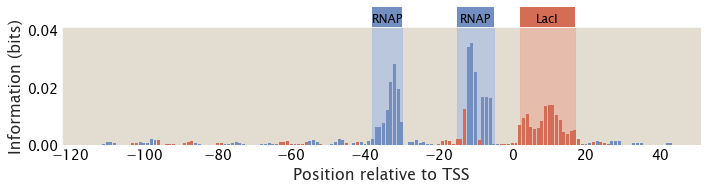

In [16]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       mutants=starter_mutants)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

Now let's try our sliding window approach

In [17]:
starter_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.1, num_mutants=10, number_fixed=True))

In [18]:
mutants = get_library(starter_mutants, window_size=10, step_size=5)

In [20]:
len(mutants)

310

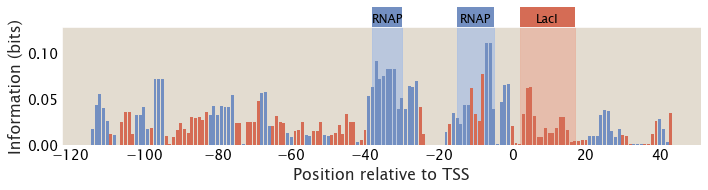

In [19]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       mutants=mutants)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

Ok let's try playing around with window sizes and step sizes

In [27]:
mutants = get_library(starter_mutants, window_size=15, step_size=5)

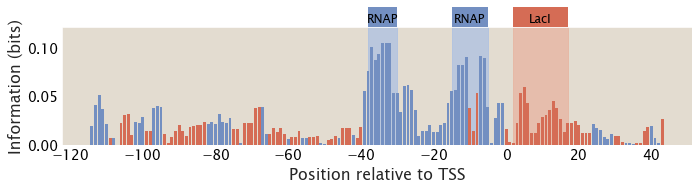

In [28]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       mutants=mutants)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

In [33]:
mutants = get_library(starter_mutants, window_size=20, step_size=5)

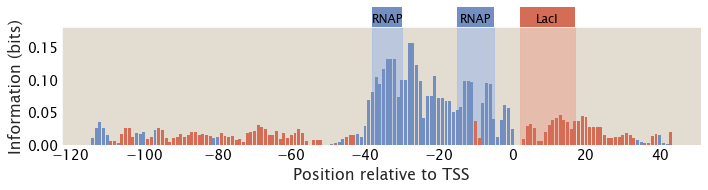

In [34]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       mutants=mutants)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

It seems like a larger window size is better.

In [78]:
starter_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.05, num_mutants=10, number_fixed=True))

In [79]:
mutants = get_library(starter_mutants, window_size=12, step_size=5)

In [80]:
len(mutants)

300

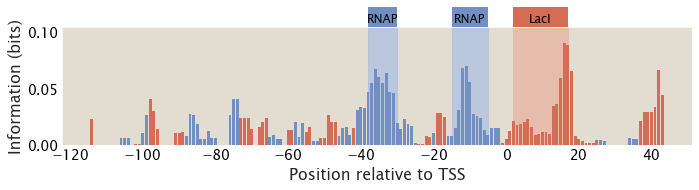

In [81]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       mutants=mutants)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

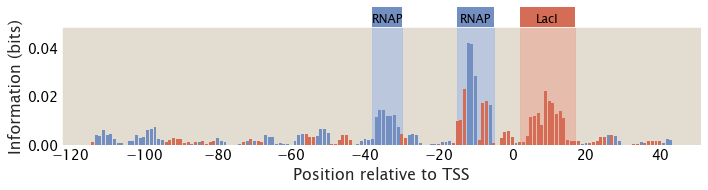

In [57]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                       *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                       num_mutants=300)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)